# Deep Residual Networks

CNN vs RESNET

Deep Learning'in en temek özelliklerinden birinin çok büyük veriler üzerinde çalışabilmesi. Buna olanak sağlayan özelliği ise "Derin" ağlar oluştumak özelliğidir. Aslında düz bir mantıkla düşünüldüğünde Layer yani katman sayısının artmasıyla problemin öğrenilmesi daha kolaylaşırdı. Yani layer sayısının problemin karmaşıklığıyla doğru orantılı şekilde artması zaten beklenen bir olaydı. Fakat bu derinlik ne kadar derin olmalıdır. Aslında bu da belirlenmesi en önemli metriklerden biriydi. CNN kullanırken layer sayısını arttırmak ilk başta bizi memnun edebilir. Öğrenme artarabilir. Fakat daha derinlere inildikçe ve layer sayısını arttırdıkça bir yerden sonra modelin öğrenmesi yavaşlayarak azalıyordu.Hatta duruyordu. Teorimiz ne yazık ki çürüdü. Bu problemin öğrenilmesiyle "Vanishing Gradient Problem " ortaya çıktı. Bu problemin üstesinden gelebilmek için RESNET geliştirildi.Vanishing Gradient Problem 'in üstesinden gelindi.

# Vanishing Gradient Problem

Bir CNN yapısı düşünelim. Ve bu CNN yapısı üç layerdan meydana gelsin. Bir image'i sınıflandırmak istediğimizi varsayarasak, ilk adımda elde etmek istediğimiz şeyler image'e ait "featrue-map" lerdir. Peki ilk layer'da image'e ait low level feature'lar , ikinci layer'da middle level feature'lar ve son layerda ise high level feature mapler elde edeceğiz. Peki bizim CNN yapımız nasıl çalışıyor. Aslında önce filtrelerimiz saysesinde ilk adımda bazı feature_map ler elde ediyoruz. Ardından elde ettiğimiz output değerinden bir "Loss" değeri elde ediyoruz. Problemimizin karmaşıklığını ve elde var olan verilern sayısına göre iterasyonlar gerçekleştirip ardından optimize etmek istediğimiz "weight" değerlerimizi güncelliyoruz. Bu güncelleme işleminin gradient(LOSS'UN WEIGHT'E GÖRE TÜREVİ) hesabı yapılıp ardından "loss" değerimizin "weight" değerimize göre türeviydi. weigt güncellenme işlemi===> (weight_new)= (weight-learning_rate*gradient).



LOSS Fonksiyonun WEIGHT'E göre türevini belirleyen şey NEURAL NETWORK YAPISININ *DERİNLİĞİ* BELİRLER.


dloss/dw2 * dw2/dw1 = dloss/dw1 Sequential (sıralı) bir model yapısı olduğu olduğu için w1 değeri adım adım ortaya çıkıyor.Her bir layer'dan geçerek.



NETWORK ÇOK DERİNSE; Amacımız weight1 değerini güncellemek; adım adım ilerlendiğinde gradient değeri türev alındıkça o kadar küçük çıkacaktır ki weigt güncelleme formülünde yerine konulduğunda;


(weight_new)= (weight-learning_rate*gradient)


weigt_new değeri neredeyse güncellenmeyecektir.Yaklşaık aynı değere sahip olacağız. Weigt güncellenmedikçe öğrenme olayı (train etme) meydana gelmeyecektir. Weigt değerini öğrenememiş olmayacaktır. Low level'da bilgi kaybı arttıkça high level'da bundan etkilenerek öğrenme işlemi ne yazık ki gerçekleşemeyecek. Ya da gerçekleşmesi uzun uzun zamanlar alacaktır. 



(Vanishing ==> gözden kaybolma) Gradient değerim kaybolacaktır. 



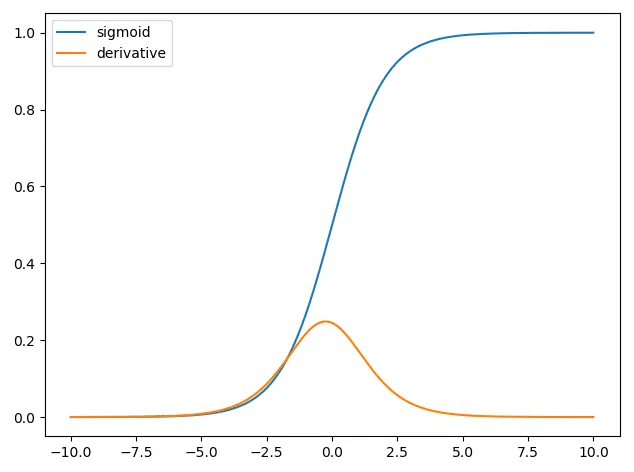

RESNET YAPISI:

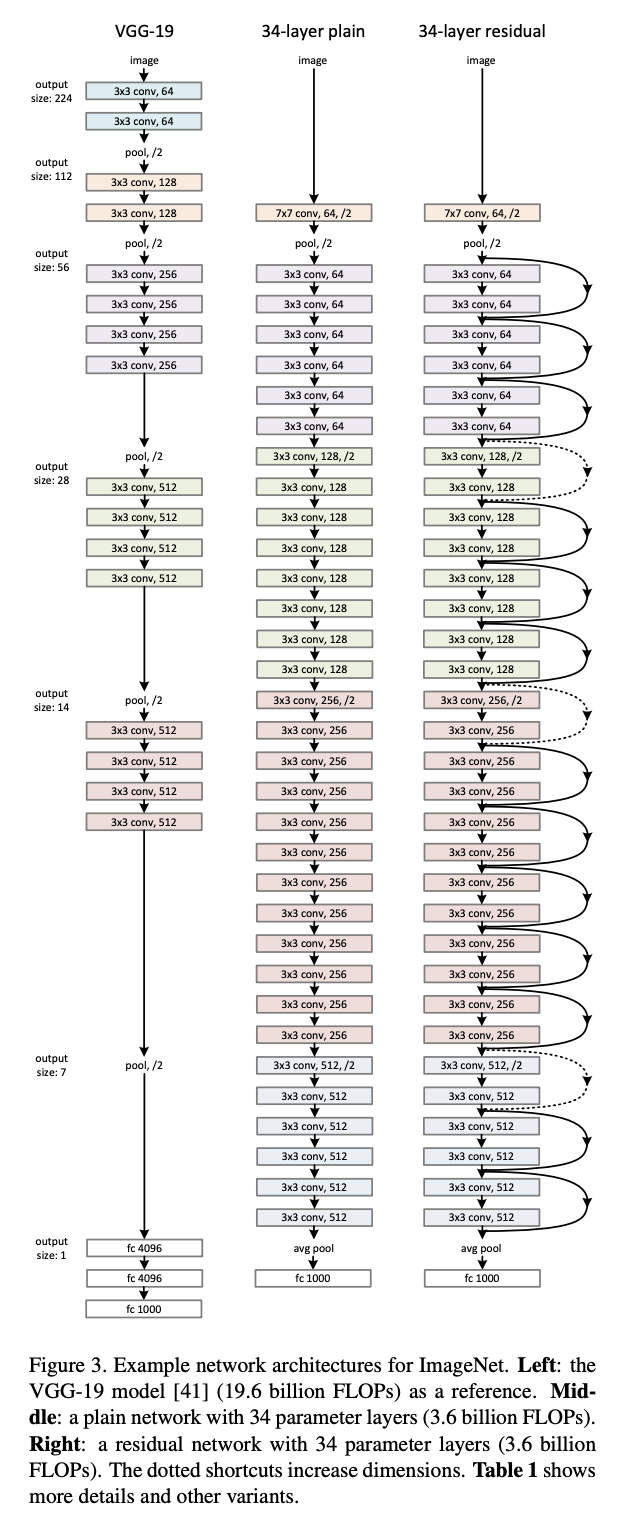

# RESNET YAPISI

REsnet yapısı aslında CNN'de var olan sequential ifadenin bozumlası ve bir "shortcut" yolunun oluşturulması. Bir layerdan bir diğer layer'a bilgi kaybının yaşanmaması için direkt bir yol ile bağlı olması durumudur. Bu yapının adı "Residual Connection" dır.

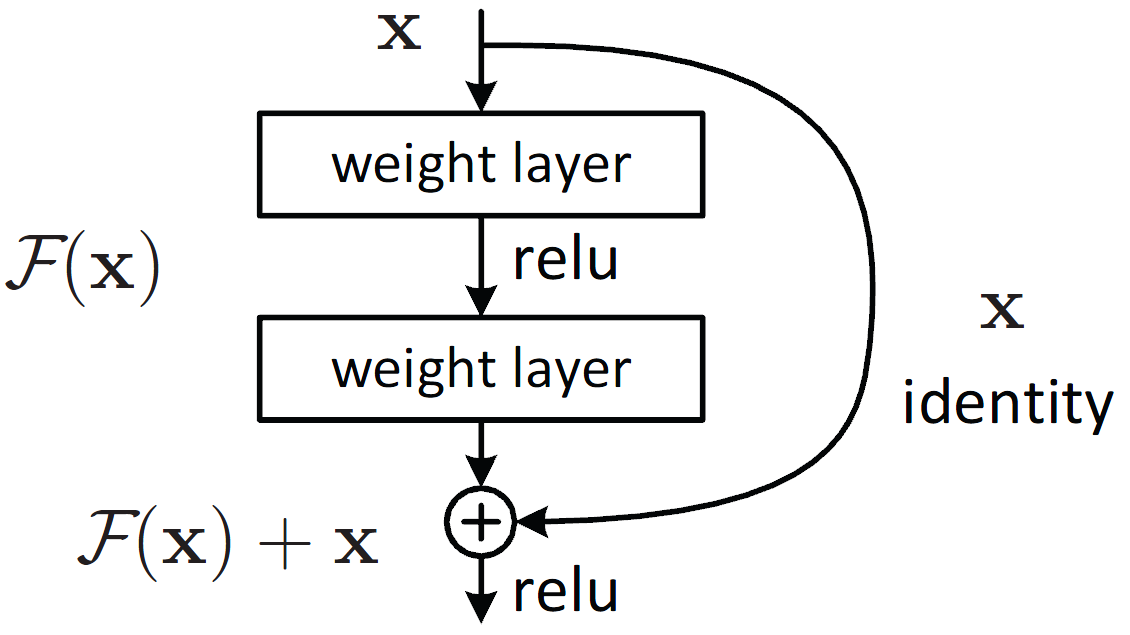

# RESNET IMPLEMENTION WITH PYTORCH

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time

Deivce Confic:

Bilgisayarlarımızda iki adet yapı mevcut bunlardan biri CPU bir diğeri ise GPU;
Neural network yapılarımız GPU'da çok daha hızlı çalıştığı için böyle bir seçim hakkımız var. Default olarak Cpu'da çalışır.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

"Cuda" indirmemiz gereken bir yapıdır.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Resimleri okumak için bir fonksiyon yazalım. Bu fonksiyon öncesinde memory'den resim sayıları* resim boyutları kadar bir array için yer ayırıyor. 

ardından verilen path içindeki her bir image açıyor ve onu bir array'e çevirip ardından flatten işlemi ile bu resimler bir vektör haline çeviriyor. 

Daha sonra buunları memory de ayırdığımız array içinde index numaralarına göre depoluyor. 

In [3]:
def read_images(path, num_img):
    array= np.zeros([num_img,64*32]) # Memory Allocation
    i=0
    for img in os.listdir(path):
        img_path= path+"//"+ img
        img= Image.open(img_path, mode="r")
        data= np.asarray(img, dtype= "uint8")
        data= data.flatten()
        array[i, :]= data
        i+=1
    return array
    

Veri setimizi tanıtalım. Veri setimizde Classification klasörü altında bir positif bir de negatif adlı iki dosya var. Positif içinde Infared görüntülerden oluşan insan resimleri bulunurken, negatfilerin içinde Infared insan ı-olmayan (ağaç, araba, tabela vs.) görüntüler var. 


Öncesinde train_negatif_path'imizi bildirip ardından içindeki resim sayısını tanımlıyoruz.

Daha sonra train_negatif_array elde etmek için yukarıda tanımladığımız "read_images" adlı fonksiyonumuzun içine dosya yolumuzu ardından içinde bulunan resim sayısını giriyoruz.

PyTorch ile implement işlemi gerçekleştireceğimiz için bu array'i torch.from_numpy fonksiyonu ile Tensor'a çevirip bu tensor'un boyutunu ekrana yazdırıyoruz.

In [4]:
train_negative_path= r"D:\veriseti\LSIFIR\Classification\Train\neg"
num_train_negative_image= 43390
train_negative_array= read_images(train_negative_path,num_train_negative_image)
x_train_negative_tensor= torch.from_numpy(train_negative_array)
print("X_Train_Negative_Tensor : ", x_train_negative_tensor.size())

X_Train_Negative_Tensor :  torch.Size([43390, 2048])


In [5]:
y_train_negative_tensor = torch.zeros(num_train_negative_image, dtype = torch.long)
print("y_train_negative_tensor:", y_train_negative_tensor.size())  

y_train_negative_tensor: torch.Size([43390])


Read_images fonksiyonumuzun içine şimdi ise insan görüntülerinin olduğu positif klasörü yolunu verip resim sayısını veriyoruz. 

Ardından elde ettiğimiz array yapısını Tensor'a çevirip size() methodu ile boyutunu görüntülüyoruz.

In [6]:
train_positive_path= r"D:\veriseti\LSIFIR\Classification\Train\pos"
num_train_positive_image= 10208
train_positive_array= read_images(train_positive_path,num_train_positive_image)
x_train_positive_tensor= torch.from_numpy(train_positive_array)
print("X_Train_positive_Tensor : ", x_train_positive_tensor.size())

X_Train_positive_Tensor :  torch.Size([10208, 2048])


Buraya kadar girdi yani inputlarımız elde ettik. Bizim train işlemini gerçekleştirebilmemiz için bir de "Label" değerlerimize ihtiyacımız var. Yani bunları insan olan görüntüleri sınıflandırmak için 1 ve insan olmayan diğer görüntüler için 0 labellarını içeren bir "Hedef öznitelik" array(tensor) ' e ihtiyacımız var. Label için "y" kullanalım. Aynı işlemleri gerçekleştirelim.

Görüldüğü üzere 10208 adet label içeren bir tensor yarattık. (Pozitif train dataset için)

In [7]:
y_train_positive_tensor= torch.ones(num_train_positive_image, dtype= torch.long)
print("Y_Train_Positive_Tensor : ",y_train_positive_tensor.size() )

Y_Train_Positive_Tensor :  torch.Size([10208])


Elimde iki adet train işlemi için veriseti var bunlardan birincisi x_train_positive_tensor ve bir diğeri ise x_train_negative_tensor bu iki verisetini birleştirip bunları bir "Train" dataseti haline getirmem gerekiyor. Bu tensorları concat işlemine tabii tutalım.

In [8]:
x_train= torch.cat((x_train_positive_tensor, x_train_negative_tensor),0)
y_train= torch.cat((y_train_positive_tensor, y_train_negative_tensor),0)
print("x_train: ",x_train.size())
print("y_train: ",y_train.size())

x_train:  torch.Size([53598, 2048])
y_train:  torch.Size([53598])


In [9]:
#read test neg (22050 sample)
test_negative_path = r"D:\veriseti\LSIFIR\Classification\Test\neg"
num_test_negative_img = 22050
test_negative_array = read_images(test_negative_path,num_test_negative_img)
x_test_negative_tensor = torch.from_numpy(test_negative_array[:20855,:])
print("x_test_negative_tensor: ",x_test_negative_tensor.size())
y_test_negative_tensor = torch.zeros(20855,dtype = torch.long)
print("y_test_negative_tensor: ",y_test_negative_tensor.size())

x_test_negative_tensor:  torch.Size([20855, 2048])
y_test_negative_tensor:  torch.Size([20855])


In [10]:
#read test positive (5944 sample)
test_positive_path = r"D:\veriseti\LSIFIR\Classification\Test\pos"
num_test_positive_img = 5944
test_positive_array = read_images(test_positive_path,num_test_positive_img)
x_test_positive_tensor = torch.from_numpy(test_positive_array)
print("x_test_positive_tensor: ",x_test_positive_tensor.size())
y_test_positive_tensor = torch.zeros(num_test_positive_img,dtype = torch.long)
#Klasör pozitif değerlere ait olduğu için 1'lerdan oluşan array'i label olarak nitelendirdik.
print("y_test_positive_tensor: ",y_test_positive_tensor.size())

x_test_positive_tensor:  torch.Size([5944, 2048])
y_test_positive_tensor:  torch.Size([5944])


In [11]:
#concat test
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)
print("x_test: ",x_test.size())
print("y_test: ",y_test.size())

x_test:  torch.Size([26799, 2048])
y_test:  torch.Size([26799])


Görselleştirmek istersek:


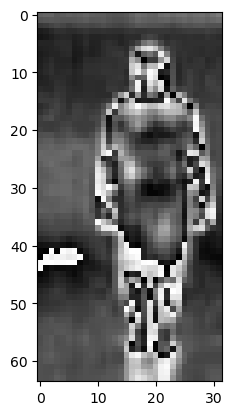

In [12]:
plt.imshow(x_train[5000,:].reshape(64,32),cmap="gray")

10208.indise kadar olan görüntülerde insan bulunmamaktadır. 10208. indisten sonrasında insan resimleri bulunmaktadır.

Datasetimizi hazırladık. Artık CNN modelimizi kurmak için hazırız.


In [13]:
# Hyperparameter
num_epochs = 10
num_classes = 2
batch_size = 8933
learning_rate = 0.00001

CNN yapısını kurmak zamanı geldi. CNN yapısının sırası nasıl olmadır. Önce COnvolution Layer1 ardından pooling işlemi, ardından ikinci layer ve pooling işlemi daha sonra fully connected yapısı ve output yapısıdır. Biz PyTorch ile implemet yapacağımız için CNN yapısını her zamankinden biraz farklı oluşturacağız. İlk olarak PyTorch kütüphanesi içinden nn.Module sınıfını kullanacağımız bir "class" yapısı oluştuacağız. Bu class nn.Module'den inheritance ediyor. Ve onun içindeki özellikleri kullanıyor. Kullanacağımız layer ve Pooling işlemlerini bu sınıf yardımıyla çağıracağız. 


sıralama şu şekilde olacaktır.

CONV1 -> Relu -> POOL -> CONV2 -> Relu -> POOL --> FLATTEN(With view in PyTorch) -> FC1 -> Relu -> Fc2 -> relu -> Fc3 -> output

In [14]:
import torch.utils.data

train = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True )


test = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False )

In [15]:
class Net(nn.Module):
    
    def __init__(self): 

        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(1,10,kernel_size = 5) #1=input, 10=output, 5=5x5'lik feature detector
        self.pool = nn.MaxPool2d(2,2)  #max pooling yöntemi ile 2x2'lik matrix feature map üzerinde gezdirilir.
        self.conv2 = nn.Conv2d(10,16,kernel_size = 5) #10=input, 16=output, 5=5x5'lik feature detector
        
        
        #fully connected layer
        self.fc1 = nn.Linear(16*13*5,520) #1.hidden layer
        self.fc2 = nn.Linear(520,130)     #2.hidden layer
        self.fc3 = nn.Linear(130,num_classes) #output layer

    #forward propagation
    def forward(self, x): 
        
        x = self.pool(F.relu(self.conv1(x))) # convolution -> relu -> pooling
        x = self.pool(F.relu(self.conv2(x))) # convolution -> relu -> pooling
        
        x = x.view(-1,16*13*5) #flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
#Böylelikle baştan sona bir step tamamlanmıştır.

loss fonksiyonu ve Optimizer'ı tanımlama sırası:

In [16]:
net = Net()


In [17]:
criterion= nn.CrossEntropyLoss()

import torch.optim as optim
optimizer= optim.SGD(net.parameters(), lr= learning_rate, momentum= 0.8)

net.parameters() parametresi ile eğiteceğimiz parametreleri alacak. Yani kullanacağımız weight ve bias değerleri input olarak alınıyor. momentum=0.8 parametresi ile SGD'nin hız ayarı yapılmıştır.

# TRAIN

In [19]:
#train a network
start = time.time() #başlangıç zamanı tutulur.
train_acc = []
test_acc = []
loss_list = []
use_gpu = False #gpu kullanmayacağım için False yaptım.

for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        #0'dan başlayarak trainloader'daki görsel sayısı kadar döner.
        
        inputs, labels = data 
        inputs = inputs.view(batch_size, 1, 64, 32) #1 değeri gray resim olduğunu ifade eder. 64,32 ise resmin size'ını ifade eder.
        inputs = inputs.float() 
        
        
        #data görselleri ve görsellerin ait olduğu classları(1,0) return eder.
        #float'a çevrilir.
        # use gpu
        if use_gpu:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
        
        #zero gradient
        optimizer.zero_grad() #her adımda türevler sıfırlanmazsa toplanarak gider..
                              #otomatik olarak sıfırlanmaz.
        
        #forward
        outputs = net(inputs)
        
        #loss
        loss = criterion(outputs, labels) #output'u label'lar ile karşılaştırarak loss'u buluruz.
        
        #Loss'u bulduğumuza göre backward propagation yapabiliriz.
        loss.backward()
        
        # update weights
        optimizer.step()
        
        #test
    correct = 0 #ne kadar doğru bilindiği
    total = 0   #ne kadar data olduğu
    with torch.no_grad(): #no_grad methoduyla back_propagation biter.
        
        for data in testloader:
            images, labels= data
            
            images = images.view(batch_size,1,64,32)#reshape
            images = images.float() #float
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = net(images)
            
            #output'un doğru mu yanlış mı olduğunu anlayalım:
            _, predicted = torch.max(outputs.data,1)
            
            #2.parametredeki 1 değeri indekslerin return edildiği anlamına gelmektedir.
            total += labels.size(0) #kaç veri bulunduğu üzerine eklenerek gider.
            correct += (predicted == labels).sum().item()
            #Toplam sonucunda sayı çıkmayacak dolayısıyla gerçek bir int sayıya çevirmek için item() metodu kullanılmıştır.
            
    acc1 = 100*correct/total  # % şeklinde accuracy değeri hesap edilmiştir.
    print("accuracy test: ",acc1)
    test_acc.append(acc1)
    
    
    # #train seti ile test edelim. Yukarıdaki test bloğundaki test ifadelerini train olarak değiştirmek yeterlidir.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels= data
            
            #reshape:
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data,1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    acc2 = 100*(correct/total)
    print("accuracy train: ",acc2)
    train_acc.append(acc2)


print("train is done.")

accuracy test:  76.73047501772454
accuracy train:  59.4070674278891
accuracy test:  92.19747005485279
accuracy train:  73.36281204522557
accuracy test:  86.09276465539759
accuracy train:  71.05489010783984
accuracy test:  91.27579387290571
accuracy train:  75.37408112242994
accuracy test:  89.7458860405239
accuracy train:  76.31628045822605
accuracy test:  91.43624762117989
accuracy train:  78.29769767528639
accuracy test:  90.14142318743237
accuracy train:  78.99361916489421
accuracy test:  90.96981230642935
accuracy train:  79.9973879622374
accuracy test:  90.80189559311914
accuracy train:  80.72316131198926
accuracy test:  90.62278443225493
accuracy train:  81.32766147990597
train is done.


RESNET kurmak için:

Bir base blok kurmak ile işe başlayacağız.

3x3 bir kernel size'ımız olacak.

In [27]:
def conv3x3(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)

In [28]:
def conv1x1(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)

In [29]:
class BasicBlock(nn.Module): 
#BasicBlok, Pytorch'un neural network Module class'ından inherite edecek. Bunun anlamı, nn.Module içerisindeki her şeyin
#kullanılabileceğidir.
    
    expansion = 1
    
    def __init__(self,inplanes, planes, stride = 1, downsample = None):
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)  #Her layer'da normalization yapmak demektir.
        self.relu = nn.ReLU(inplace = True)  
#inplace = True parametresi ile Relu aktivasyon fonksiyonunu çağırdıktan sonra sonucunun kendisine eşitlenmesi sağlanmıştır.
        self.drop = nn.Dropout(0.9) #%90'ının drop yapılması sağlanmıştır.
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
 
#Bu kısma kadar basic blok tamamlanmıştır. Şimdi bunları birbirine bağlayalım:

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out


Kullanacağımız neural network yapılarını birer fonksiyon halinde yazdık. Öncesinde def Conv3x3 içerisine inplanes(input channel), out_planes(output channel, layer’daki nöron sayımızdır.) ardından stride =1 bu ise filtrenin yalnızca tek hücre kaymasını sağlayan opsiyondur.  Ardından return nn.Conv2d(inplanes, out_planes, kernel_size=3,stride=stride, padding=1, bias=False). Zaten tanımlarken 3x3 yaptığımız için kernel_size değerimizi de 3 belirledik. Padding ise bir filtre resim üzerinde gezindiğinde output değerimiz resmin boyutundan daha küçük çıkar. Bu sebeple padding resmin etrafına bir çerçeve çizer. Bu şekilde output image boyutu korunmuş olur. Bias false seçilmiştir her katmandan sonra BatchNormalizasyon işlemi gerçekleştireceğimiz için bias değerinin varlığına gerek kalmıyor. 

Def conv1x1(in_planes, outplanes,stride=1):	
return nn.Conv2d(inplanes, out_planes, kernel_size=3,stride=stride, padding=1, bias=False) Aynı özelliklere sahip bir ikinci layer tanımladık.


Basic Block içinde layer’larımızı initialize edip ardında bunları birleştireceğiz.
Class BasicBlock (nn.Module):
Expansion=1 

Def __init__(self, inplanes, outplanes, stride=1, downsample=None) 
Super(BasicBlock,self)__init__()  #nn.Module’den inherit etmesi için
Self.conv1= conv3x3(inplanes, planes, stride=stride )
Self.bn1= nn.BatchNorm2d(planes) #Her layerın sonucunu normalize etmek 
Self.relu= nn.ReLu(inplace=True) #inplace=True reluyu uyguladıktan sonra sonucu kendine eşitle
Self.drop= nn.Dropout(0.9) #Bazı node’ları devre dışı bırakarak overfitting önüne geçmek
Self.conv2= conv3x3(planes, planes)
Self.bn2= nn.BatchNorm2d(planes) #Her layerın sonucunu normalize etmek 
Self.downsample= downsample
Self.stride= stride





#Bacis bloklar hazır şimdi forward methodu ile bu blokları birbirine bağlamak kaldı. Burada bağlantı bildiğimiz gibi aynı şekilde kuruluyor fakat farklı olarak x girdisinin layerlardan geçmeden önceki hali tüm layerlardan geçmiş hali ile toplanıyor. Eğer layerlardan geçmiş out değişkeni boyutu giren x değişkeni boyutu ile aynı olmaz ise diye bir downsample şartı yazılıyor. Çünkü filtrrelenmiş görsellerin boyutunun normal şartlar altında olduğu halinden daha küçük olduğunu biliyoruz. 	
Def forward(self, x)
İdentity= x #shortcut’u tanımlayacağız

Out= Self.Conv1(x)
Out= self.bn1(out)
Out= self.reLu(out)
Out= Self.dropout(out)
Out= self.conv2d(out)
Out= self.bn2(out)
Out= self.drop(out)
İf self.downsample is not ,None:
İdentity= self.downsample(x)  #Eğer boyutlar tutmazsa toplanamazlar
Out= out+identity  Sonuç + identity shortcut
Out= self.reLu(out)
Return out

##Resnet yapısını kurmak için diğer neural network yapılarından farklı olarak __make_layer() methodu kullanacağız. 	Make_layer methodu içerisine bir basic block, planes(input channeler) ardndan bir de blocks (kaç bloktan oluşacağının bilgisini)  ve stride bilgisini alır. Stride’ın bir olup olamması bizim için önemli eğer stride bir ise downsample olmayacak fakat birden farklı ise downsample olacak. Downsample aktif olup olmayacağı bilgisini make_layer methodunda karar vereceğiz.  Eğer stride !=1 ya da self.inplanes != planes*block.expansion  (girdi kanal sayısının size değeri çıktı kanal sayısının size değerine eşit olmadığı durumlarda) downsample işlemi gerçekleşecek. 

Downsample içeriği ise aslıda size boyutlarını biribirine eşit hale getimek işlemi çünkü bu çıktılar toplanacak. (expansion her zaman için  1 tanımadık). 
Ardından make_layer methonunun bizim için layer oluşturmasını istedğimiz için ;
 Layers adlı boş bir liste tanımaldık.
Layers.append methodu ile basic block yapımızın aynısından bize oluştuması için parametreleri verdik.
Layer.append((block(self.inplanes, planes, stride, downsample))
Self.inplanes= planes*block.expansion
For _ in range(1, blocks) #birden başladık çünkü base block+ 
Return nn.Sequential (*layers)  # oluşturulan layersları bize return etmesini sağladık.
Def resnet(nn.Module):







 



In [30]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes = num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride = 2, padding = 3, bias= False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
    
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def _make_layer(self, block, planes, blocks, stride = 1):  
        #_make_layer metodu ile amaçlanan, basic metodları ard arda koyarak yeni bir yapı oluşturmaktır.
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.inplanes, planes*block.expansion, stride),
                    nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,blocks):
            layers.append(block(self.inplanes, planes))
        
        return nn.Sequential(*layers)
        
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1) #Flatten işlemi gerçekleştirilmiştir. Shape değerleri view metodu ile değiştirilmiştir.
        x = self.fc(x)
        
        return x

In [31]:
device

device(type='cpu')

In [32]:
model = ResNet(BasicBlock, [2,2,2]).to(device)


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
# train

loss_list = []
train_acc = []
test_acc = []
use_gpu = False

total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.view(batch_size,1,64,32)
        images = images.float()
        
        # gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 2 == 0:
            print("epoch: {} {}/{}".format(epoch,i,total_step))

    # Her epoch'un sonunda sonuçları görmek istiyoruz. Train ve Test setlerine göre sonuçları görelim:
    # train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images)  #Resimleri modele verip prediction yapılmıştır.
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    # test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy test %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    loss_list.append(loss.item())

epoch: 0 0/6
epoch: 0 2/6
epoch: 0 4/6
Accuracy train 65 %
Accuracy test 74 %
epoch: 1 0/6
epoch: 1 2/6
epoch: 1 4/6


In [ ]:
#%% visualize

fig, ax1 = plt.subplots()
plt.plot(loss_list,label = "Loss",color = "black")
ax2 = ax1.twinx()
ax2.plot(np.array(test_acc)/100,label = "Test Acc",color="green")
ax2.plot(np.array(train_acc)/100,label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
fig.tight_layout()
plt.title("Loss vs Test Accuracy")
plt.show()